##### ASakai
https://github.com/AtsushiSakai/PythonRobotics/blob/master/Localization/extended_kalman_filter/extended_kalman_filter_localization.ipynb

##### RLabbe
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

In [1]:
import os
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [2]:
os.path.join(os.getcwd(), 'data')

'C:\\Users\\ljcbs\\uchicago\\robotics\\coppelia_robotics\\notebooks\\data'

In [3]:
file_path = os.path.join(os.getcwd(), 'data')
#file_path = os.path.join(os.getcwd())
drive_file = 'KF_withOdometer.json'
# message_file = 'drive_messages_200703.json'

def load_json_fstr(fstr):
    with open(os.path.join(file_path, fstr), 'r') as f:
        res = json.load(f)
    return res

drive_data = load_json_fstr(drive_file)
# message_data = load_json_fstr(message_file)

In [4]:
pprint(drive_data)
# pprint(message_data)

[{'actual_x': -3.7217729091644287,
  'actual_y': 0.21832309663295746,
  'gps_x': -3.8081783097425657,
  'gps_y': 0.1390060337466093,
  'odometer_x': -3.7217795872369606,
  'odometer_y': 0.2183607635284675},
 {'actual_x': -3.7218981981277466,
  'actual_y': 0.23484578728675842,
  'gps_x': -3.7034669749185385,
  'gps_y': 0.18500609116226538,
  'odometer_x': -3.72192572801059,
  'odometer_y': 0.2517133601360251},
 {'actual_x': -3.722267985343933,
  'actual_y': 0.2836853265762329,
  'gps_x': -3.7037764936326623,
  'gps_y': 0.26208253145946186,
  'odometer_x': -3.7221654209854242,
  'odometer_y': 0.28595340383400414},
 {'actual_x': -3.722982406616211,
  'actual_y': 0.3323434442281723,
  'gps_x': -3.6889566506754075,
  'gps_y': 0.4215435863081488,
  'odometer_x': -3.7225906654429637,
  'odometer_y': 0.32014300079101365},
 {'actual_x': -3.7244715690612793,
  'actual_y': 0.3810742497444153,
  'gps_x': -3.798347459047316,
  'gps_y': 0.42369755852666874,
  'odometer_x': -3.7232268245595903,
  'od

Set Initial Conditions

In [18]:
prior_dat = {
#     't': drive_data[0].get('t'),
    'gps_x': 0,
    'gps_y': 0, 
    'odometer_x': 0,
    'odometer_y': 0,
    'x_true':0,
    'y_true':0
#     'theta_control': drive_data[0].get('theta_control'),
#     'theta_sensor': drive_data[0].get('theta_control')
}

x_true = np.array([0, 0])

F = np.identity(2)
P = np.identity(2)
H = np.identity(2)
Q = np.zeros([2,2])
R = np.zeros([2,2])

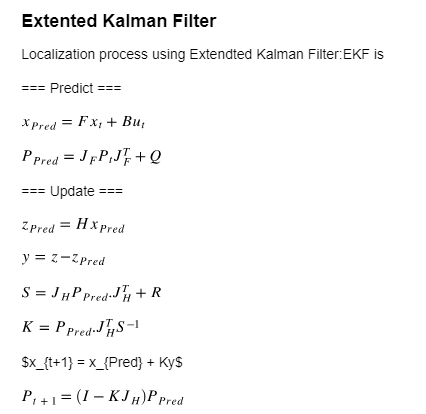

In [19]:
for i, curr_dat in enumerate(drive_data, 1):
#     dt = curr_dat['t'] - prior_dat['t']
#     u_t_sensor = np.array(
#         [curr_dat['gps_x'] - prior_dat['gps_x'],
#          curr_dat['gps_y'] - prior_dat['gps_y']])
#          curr_dat['theta_control'] - prior_dat['theta_control']])
    u_t_sensor = np.array(
        [curr_dat['gps_x'] - prior_dat['x_true'],
         curr_dat['gps_y'] - prior_dat['y_true']])
    
    u_t_control = np.array(
        [curr_dat['odometer_x'] - prior_dat['odometer_x'],
         curr_dat['odometer_y'] - prior_dat['odometer_y']])
#          curr_dat['theta_sensor'] - prior_dat['theta_sensor']])
    
    r_control = 10e-2
    J_control = np.array([
        [1, 0],
        [0, 1]])
    
    r_sensor = 10e-2
    J_sensor = np.array([
        [1, 0],
        [0, 1]])
    
    # What to plugin to alpha 1-4?
    # alpha_1, alpha_2, alpha_3, alpha_4 = 10e-7, 15e-7, 5e-7, 20e-7
    # alphas are for gps
    # gps uniform(-.1, .1)
    # q_alphas are for odometer, what is a calculation for these?
    
    alpha_1, alpha_2, alpha_3, alpha_4 = (100,) * 4
    qalpha_1, qalpha_2, qalpha_3, qalpha_4 = (1,) * 4
    
    R_t_1_1 = alpha_1 + alpha_2 
    R_t_2_2 = alpha_3 + alpha_4
    R = np.array([
        [R_t_1_1, 0],
        [0, R_t_2_2]
    ])
    
    Q_t_1_1 = qalpha_1 + qalpha_2 
    Q_t_2_2 = qalpha_3 + qalpha_4 
    Q = np.array([
        [Q_t_1_1, 0],
        [0, Q_t_2_2]
    ])
    
    # === Predict ===
    x_pred_control = x_true + u_t_control
    x_pred_sensor = x_true + u_t_sensor
    P_pred = J_control.dot(P).dot(J_control.T) + Q
    # === Update ===
    z_pred_control = H.dot(x_pred_control)
    z_pred_sensor = H.dot(x_pred_sensor)
    y = z_pred_sensor - z_pred_control
    S = J_sensor.dot(P_pred).dot(J_sensor.T) + R
    K = P_pred.dot(J_sensor.T).dot(np.linalg.inv(S))
    x_true = x_pred_control + K.dot(y)
    
    # Review
    print(
        f"x_true: {x_true}"
        # f"\nP {P}"
        f"\ny: {y}"
        f"\n"
    )
    # Setup for Next Iteration
    curr_dat['x_true'] = x_true[0]
    curr_dat['y_true'] = x_true[1]
    prior_dat = curr_dat
        

x_true: [-3.72305642  0.21718803]
y: [-0.08639872 -0.07935473]

x_true: [-3.7229109   0.24957214]
y: [ 0.01973558 -0.06553454]

x_true: [-3.72286427  0.28349106]
y: [ 0.0193741  -0.02172965]

x_true: [-3.72278214  0.31921557]
y: [0.03433287 0.10386293]

x_true: [-3.72452562  0.35430075]
y: [-0.07492916  0.07043776]

x_true: [-3.72671936  0.39034639]
y: [-0.09936314  0.13520169]

x_true: [-3.72762337  0.42434339]
y: [-0.01193852 -0.00367246]

x_true: [-3.72907419  0.46089688]
y: [-0.04731191  0.11148418]

x_true: [-3.7299404   0.49905651]
y: [ 0.00592529 -0.01368434]

x_true: [-3.73185661  0.53451264]
y: [-0.06558423  0.05383825]

x_true: [-3.73209942  0.56539885]
y: [0.04481834 0.06028136]

x_true: [-3.73395732  0.59975465]
y: [-0.04952372  0.09637014]

x_true: [-3.73652747  0.63605648]
y: [-0.08876324  0.12855226]

x_true: [-3.73694486  0.66842575]
y: [0.05121854 0.12308013]

x_true: [-3.73711195  0.70524401]
y: [0.08541055 0.19723554]

x_true: [-3.73827515  0.74115605]
y: [0.02179271

In [7]:
print(drive_data[-1])

{'actual_x': 2.5990443229675293, 'actual_y': 3.937337875366211, 'odometer_x': 0.5568146854729561, 'odometer_y': 4.609535900135582, 'gps_x': 2.5032321101748267, 'gps_y': 3.9217973807530275, 'x_true': 2.486191012933144, 'y_true': 4.042469962833819}


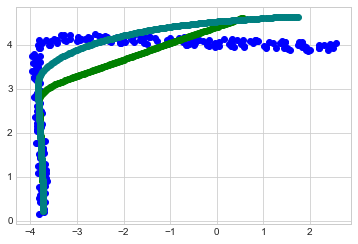

In [20]:
gps_x = [dat.get('gps_x') for dat in drive_data]
gps_y = [dat.get('gps_y') for dat in drive_data]
odometer_x = [dat.get('odometer_x') for dat in drive_data]
odometer_y = [dat.get('odometer_y') for dat in drive_data]
x_true = [dat.get('x_true') for dat in drive_data]
y_true = [dat.get('y_true') for dat in drive_data]

fig = plt.figure()
plt.plot(gps_x, gps_y, 'o', color='blue')
plt.plot(odometer_x, odometer_y, 'o', color='green')
plt.plot(x_true, y_true, 'o', color='teal')
plt.show()
# fig.savefig('plot.png')

In [9]:
print(K.dot(y))

[ 0.00255616 -0.01810089]


In [10]:
print(K)

[[0.13043478 0.        ]
 [0.         0.13043478]]


In [11]:
R = np.zeros([3,3])
print(R)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
